# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

The goal is to identify what factors make used cars more or less expensive. We want to examine this dataset to find which features (e.g. model, condition, odometer, etc) are most strongly correlated with the car's sale price. We will also develop some models to predict car price, to help used car salespeople get an idea of how cars in their inventory can be expected to sell.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('data/vehicles.csv')
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

Lets inspect the least populated columns to see whether it's feasible to impute values, or better to just drop them altogether

In [4]:
df['VIN'].unique()

array([nan, '3GTP1VEC4EG551563', '1GCSCSE06AZ123805', ...,
       '2HGES15535H620534', '1FDWF37P64EA24868', 'SAJGX2749VCOO8376'],
      dtype=object)

Probably want to drop VIN. Unlikely to be helpful for analysis, and it contains a lot of null values.

In [5]:
df['title_status'].unique()

array([nan, 'clean', 'rebuilt', 'lien', 'salvage', 'missing',
       'parts only'], dtype=object)

We can keep it initially (and impute 'unknown' in place of the NaNs), but if the models become too hard to train due to the number of features, I might cut this out (since it'll need to be one-hot encoded).

In [6]:
df['cylinders'].unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       'other', '3 cylinders', '10 cylinders', '12 cylinders'],
      dtype=object)

Can probably convert cylinders into a numerical feature (# of columns, 0-12 and drop the 'other' ones?). This could help the model reason more effectively about the cylinders (and keep the model size down, since we then wouldn't need to one-hot encode this feature).

In [7]:
df['fuel'].unique()

array([nan, 'gas', 'other', 'diesel', 'hybrid', 'electric'], dtype=object)

Should fill NaN values as 'other' for the fuel column.

In [8]:
df['size'].unique()

array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
      dtype=object)

Reasonably clean set of values, but seems dubious to fill these kinds of values (e.g. by filling with the most common value). Might be better to drop this feature? Or could try an approach I saw recommended in the discussion for this exercise--fill in all nan values with "unknown" as a string.

In [9]:
df['manufacturer'].unique()

array([nan, 'gmc', 'chevrolet', 'toyota', 'ford', 'jeep', 'nissan', 'ram',
       'mazda', 'cadillac', 'honda', 'dodge', 'lexus', 'jaguar', 'buick',
       'chrysler', 'volvo', 'audi', 'infiniti', 'lincoln', 'alfa-romeo',
       'subaru', 'acura', 'hyundai', 'mercedes-benz', 'bmw', 'mitsubishi',
       'volkswagen', 'porsche', 'kia', 'rover', 'ferrari', 'mini',
       'pontiac', 'fiat', 'tesla', 'saturn', 'mercury', 'harley-davidson',
       'datsun', 'aston-martin', 'land rover', 'morgan'], dtype=object)

In [10]:
df['condition'].unique()

array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
      dtype=object)

We can likely use ordinal encoding on condition. Ordering seems to be new > like new > excellent > good > fair > salvage > nan

In [11]:
df['drive'].unique()

array([nan, 'rwd', '4wd', 'fwd'], dtype=object)

In [12]:
df['paint_color'].unique()

array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

In [13]:
# Do the range of values for price seem reasonable?
df['price'].describe()

,price
count,4.268800e+05
mean,7.519903e+04
std,1.218228e+07
min,0.000000e+00
25%,5.900000e+03
50%,1.395000e+04
75%,2.648575e+04
max,3.736929e+09


The minimum seems too low (I don't think free cars are relevant to our business application). The maximum also seems suspect (3 billion for a car?! We'll need to look closer to see if it's plausible at all). In any event, I suspect we'll want to limit our data to only cars within a certain "reasonable" price range, to exclude data entry errors or other anomalies.

In [14]:
# Do the range of values for odometer readings seem reasonable?
df['odometer'].describe()

,odometer
count,4.224800e+05
mean,9.804333e+04
std,2.138815e+05
min,0.000000e+00
25%,3.770400e+04
50%,8.554800e+04
75%,1.335425e+05
max,1.000000e+07


It also seems that we may have some data problems here. An odometer reading of 10 million miles seems highly suspect, and could be the result of a mistake during data entry.

In [15]:
# What do the statistics look like if we limit odometer values to cut out obvious outliers?
df[df['odometer']<1000000]['odometer'].describe()

,odometer
count,421841.000000
mean,92528.716298
std,70638.051119
min,0.000000
25%,37618.000000
50%,85339.000000
75%,133200.000000
max,999999.000000


Next, I want to look at the cars whose reported odometer reading is 0. If there are any cars in this set whose condition is not new, then maybe we should exclude them (they should not have 0 miles if they are not brand new).

In [16]:
cars_with_0_miles = df[df['odometer']==0]
cars_with_0_miles.shape

(1965, 18)

In [17]:
cars_with_0_miles.groupby(['condition'])[['condition']].count()

,condition
condition,
excellent,599
fair,28
good,110
like new,11
new,8
salvage,4


I think we should exclude these cars from the dataset during our data preparation step (except for the ones whose condition is 'new'), since they might confuse the model.

## Initial visualizations

Text(0.5, 0, 'Price (USD)')

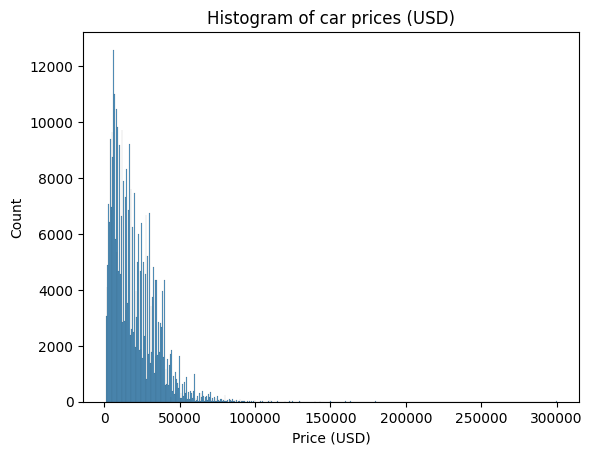

In [18]:
# Histogram of car prices (filtering for a reasonable range to exclude outliers and possible incorrect entries)
sns.histplot(data=df[(df['price'] > 1000) & (df['price'] < 300000)], x='price')
plt.title("Histogram of car prices (USD)")
plt.xlabel("Price (USD)")

Text(0.5, 0, 'Odometer reading (miles)')

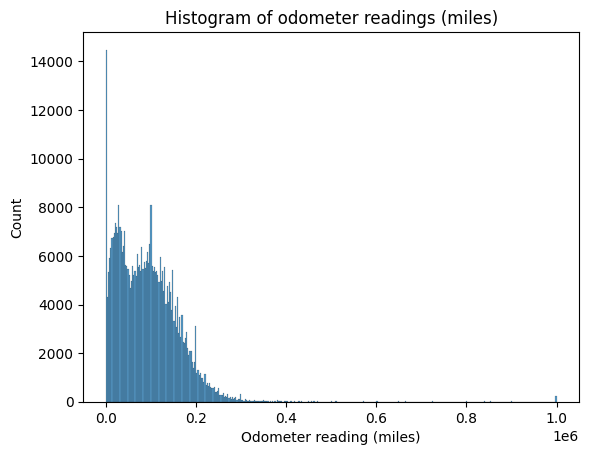

In [19]:
# Histogram of odometer readings (filtering for a reasonable range)
sns.histplot(data=df[(df['odometer'] < 1000000)], x='odometer')
plt.title("Histogram of odometer readings (miles)")
plt.xlabel("Odometer reading (miles)")

We can see that the vast majority of cars have under 350k or 400k miles on their odometer. Interestingly, there's an uptick around 1 million, which is rather surprising. There's also a high volume of cars with 0 miles on the odometer, which is a little strange for a used car dataset. This makes me wonder if those are also the result of data entry errors. I'm going to investigate further.

## Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [5]:
# Filter out rows with prices < $1000 and > $300k, to keep things reasonable and avoid weird outliers.
df_clean = df[(df['price'] > 1000) & (df['price'] < 300000)]

In [6]:
# Drop VIN, since it's unlikely to be helpful in our analysis, and is largely incomplete
df_clean = df_clean.drop(['VIN'], axis=1)

# Also drop ID, as it's not useful for analysis
df_clean = df_clean.drop(['id'], axis=1)

In [7]:
# Turn the cylinders column into a numerical one
def get_cylinders_as_int(s):
  # We should only get values in the form "x cylinders".
  # All others will be dropped before this function is applied
  return s.split(' ')[0]

df_clean = df_clean.dropna(subset=['cylinders'])
df_clean = df_clean[df_clean['cylinders'] != 'other']
df_clean['cylinders_num'] = df_clean['cylinders'].apply(get_cylinders_as_int)

<ipython-input-7-5e1cb05e93c3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['cylinders_num'] = df_clean['cylinders'].apply(get_cylinders_as_int)


In [8]:
# Filter out rows where the odometer value is overly large or small, as these may indicate data entry errors
df_clean = df_clean[(df_clean['odometer'] > 1000) & (df_clean['odometer'] < 500000)]

In [9]:
# Out of curiosity, what are the summary statistics of the dataset after filtering?
df_clean.describe()

,price,year,odometer
count,218292.000000,217359.000000,218292.000000
mean,18231.190635,2010.210274,101327.909864
std,14702.825734,9.417411,62568.706775
min,1003.000000,1900.000000,1001.000000
25%,7000.000000,2007.000000,50013.750000
50%,13995.000000,2012.000000,97300.000000
75%,26590.000000,2016.000000,142108.500000
max,299991.000000,2022.000000,499232.000000


### Visualizations after cleaning data

Let's visualize some of the important features again, after our cleaning.

Text(0.5, 0, 'Price (USD)')

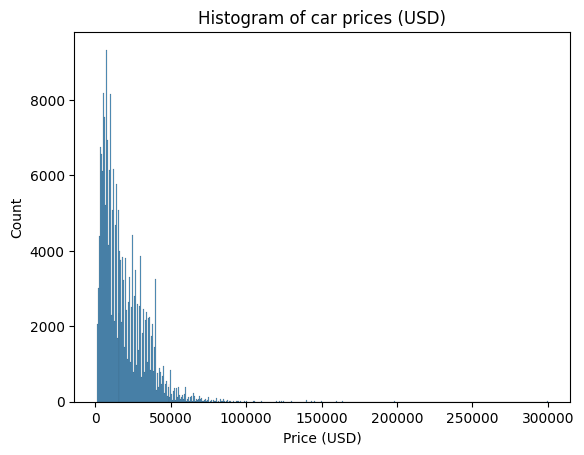

In [25]:
# Histogram of car prices
sns.histplot(data=df_clean, x='price')
plt.title("Histogram of car prices (USD)")
plt.xlabel("Price (USD)")

Text(0.5, 0, 'Odometer reading (miles)')

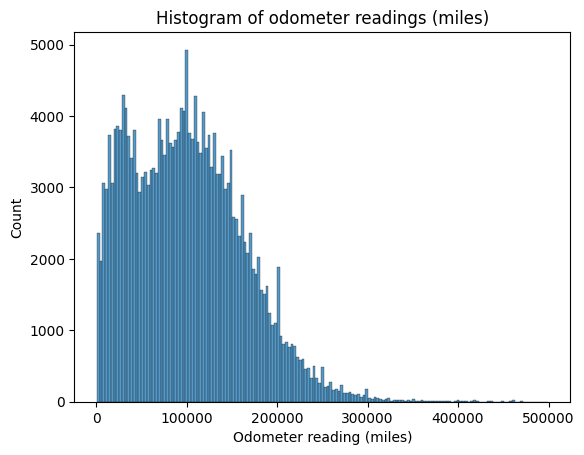

In [26]:
# Histogram of odometer readings
sns.histplot(data=df_clean, x='odometer')
plt.title("Histogram of odometer readings (miles)")
plt.xlabel("Odometer reading (miles)")

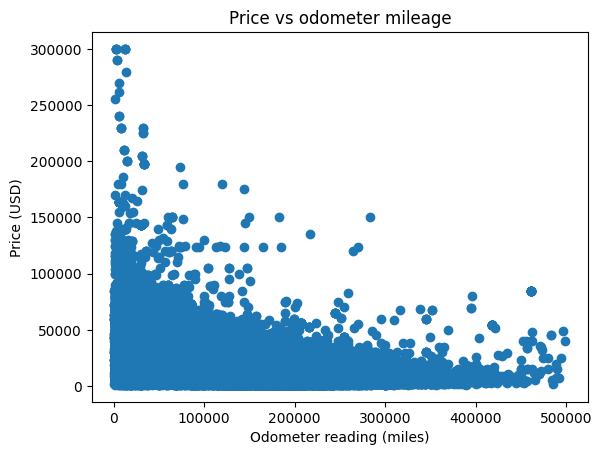

In [14]:
# Scatterplot of odometer reading vs price
plt.scatter(df_clean['odometer'], df_clean['price'])
plt.title("Price vs odometer mileage")
plt.xlabel("Odometer reading (miles)")
plt.ylabel("Price (USD)")
plt.show()

Let's also take a quick look at the correlation between odometer reading and price, since the graph doesn't show an especially strong correlation.

In [19]:
# Now that we have a clean dataset, what's the correlation between odometer and price?
r = np.corrcoef(df_clean['odometer'], df_clean['price']) # Move this elsewhere, don't leave it in the analysis.
r

array([[ 1.        , -0.53908225],
       [-0.53908225,  1.        ]])

As the graph seemed to suggest, there is a general negative correlation between odometer reading and price, but it's not particularly strongly correlated.

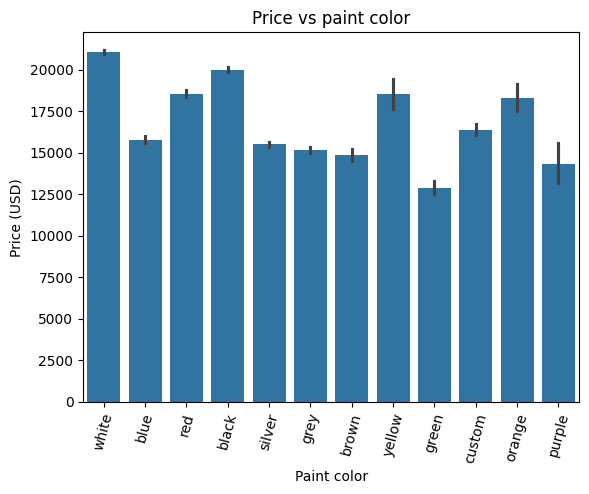

In [28]:
sns.barplot(data=df_clean, x='paint_color', y='price')
plt.title("Price vs paint color")
plt.xlabel("Paint color")
plt.ylabel("Price (USD)")
plt.xticks(rotation=75)
plt.show()

It looks like paint color has a nontrivial effect on car sale price! In particular, "standard" colors like black and white are most likely to sell for a high price, whereas nonstandard colors like green and purple have some of the lowest sale prices on average.

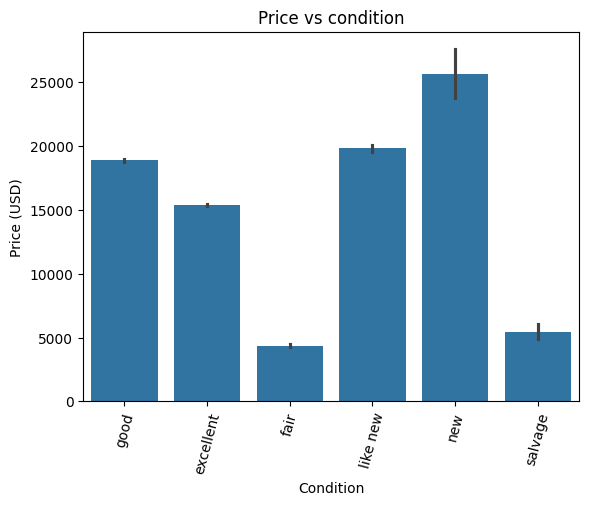

In [29]:
sns.barplot(data=df_clean, x='condition', y='price')
plt.title("Price vs condition")
plt.xlabel("Condition")
plt.ylabel("Price (USD)")
plt.xticks(rotation=75)
plt.show()

This plot is quite informative. Surprisingly enough, cars with "good" condition actually seem to sell for higher prices than cars in "excellent" condition. And cars in "fair" or "salvage" condition sell for extremely low prices compared to all other conditions.

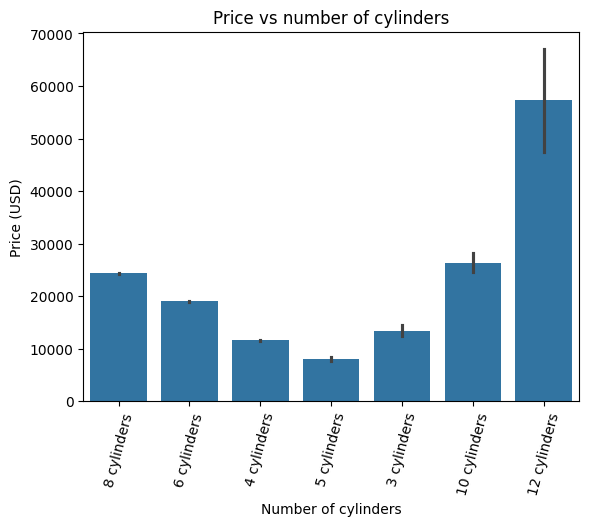

In [30]:
sns.barplot(data=df_clean, x='cylinders', y='price')
plt.title("Price vs number of cylinders")
plt.xlabel("Number of cylinders")
plt.ylabel("Price (USD)")
plt.xticks(rotation=75)
plt.show()

It looks like the number of cylinders is a very strong predictor of sale price! Cars with 12 cylinders tend to have much higher sale prices than cars with any other number of cylinders.

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

First, I'll set up the column transformer, since a lot of my remaining data processing needs to happen here (one-hot encoding categorical features, and imputing missing values).

In [26]:
# transformer = make_column_transformer(())

transformer = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))],
    remainder='passthrough'  # Keep the remaining columns
)

imp = SimpleImputer(missing_values=np.nan, strategy='constant')

In [27]:
# Test train split
X = df_clean[['year', 'cylinders_num', 'odometer', 'state', 'model', 'paint_color', 'condition']]
y = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

#### Basic linear regression

In [28]:
pipe = Pipeline([('ohe', transformer), ('imp', imp), ('scale', StandardScaler(with_mean=False)), ('linreg', LinearRegression())])


In [29]:
pipe.fit(X_train, y_train)
train_score = pipe.score(X_train, y_train)
train_score

0.8031144430251331

In [30]:
test_score = pipe.score(X_test, y_test)
test_score

0.7123871681929379

In [31]:
mean_squared_error(y_test, pipe.predict(X_test))

62026966.33861143

In [32]:
# Calculate RMSE
np.sqrt(mean_squared_error(y_test, pipe.predict(X_test)))

7875.720052072155

In [33]:
# For reference--what is the mean car price in the dataset? And the standard deviation?
df_clean['price'].mean(), df_clean['price'].std()

(18231.190634562878, 14702.825734421196)

The test RMSE is around 9,300, which suggests we can predict a car price with around \$9.3k of error. There is room to improve on this, considering that the mean car price in the dataset (after filtering) was $18k, and the standard deviation is around \$14.7k

#### Attempt label-encoding the "model" column

I want to try using polynomial features, but currently, we have a ton of features in part because we're one-hot encoding the "model" column (which has a ton of unique values). I know that there may be some issues with label-encoding the model column, but I want to explore whether it'll work at all or not.

In [73]:
label_enc_transformer = ColumnTransformer(
    transformers=[('labelenc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['model']),
     ('onehot', OneHotEncoder(handle_unknown='ignore'), ['state', 'paint_color', 'condition'])],
    remainder='passthrough'  # Keep the remaining columns
)
label_enc_pipe = Pipeline([('ohe', label_enc_transformer), ('imp', imp), ('scale', StandardScaler(with_mean=False)), ('linreg', LinearRegression())])


In [62]:
label_enc_pipe.fit(X_train, y_train)
label_enc_train_score = label_enc_pipe.score(X_train, y_train)
label_enc_train_score

0.45903961547373184

In [47]:
label_enc_test_score = label_enc_pipe.score(X_test, y_test)
label_enc_test_score

0.4630430832392679

In [48]:
label_enc_pipe.named_steps['linreg'].coef_.shape

(75,)

This actually hurt the performance quite a lot (although it did succeed in reducing the feature set significantly). Unfortunately I don't think this will be a good avenue to explore, since label-encoding is likely confusing the model with its integer-valued encodings for the vehicle models.

#### Polynomial regression

This actually turned out to be far too expensive for any degree > 1, because of the large feature set introduced when we one-hot encode the vehicle model category.

In [86]:
poly_pipe = Pipeline([('ohe', transformer), ('imp', imp), ('scale', StandardScaler(with_mean=False)), ('pf', PolynomialFeatures(degree=1)), ('linreg', LinearRegression())])


In [87]:
poly_pipe.fit(X_train, y_train)
train_score_poly = poly_pipe.score(X_train, y_train)
train_score_poly

0.8031144430251331

In [88]:
test_score_poly = poly_pipe.score(X_test, y_test)
test_score_poly

0.7123871681953039

### Ridge regression

In [82]:
# First we can try this with the ordinal encoder transformer, and then we can also try the standard OHE for model column
ridge_pipe = Pipeline([('ohe', transformer), ('imp', imp), ('scale', StandardScaler(with_mean=False)), ('ridge', Ridge(alpha=5.0))])

ridge_grid = GridSearchCV(ridge_pipe, param_grid={'ridge__alpha': [10.0, 50.0, 500.0, 5000.0, 10000.0]})
ridge_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa189f760b0>)])),
                                       ('imp',
                                        SimpleImputer(strategy='constant')),
                                       ('scale',
                                        StandardScaler(with_mean=False)),
                                       ('ridge', Ridge(alpha=5.0))]),
             param_grid={'ridge__alpha': [10.0, 50.0, 500.0, 5000.0, 10000.0]})

In [83]:
ridge_train_score = ridge_grid.score(X_train, y_train)
ridge_train_score

0.8019266813432462

In [84]:
ridge_test_score = ridge_grid.score(X_test, y_test)
ridge_test_score

0.7153038831406204

In [176]:
# View the optimal params selected by the model
ridge_grid.best_params_

{'ridge__alpha': 5000.0}

Interesting that the alpha could go all the way up to 5000 before we saw a decline in model cross-validation performance. But in any event, alpha had a fairly minimal effect on model performance (bringing test score from 0.712 to 0.715).

In [178]:
# Calculate test RMSE for best-performing ridge regression model
np.sqrt(mean_squared_error(y_test, ridge_grid.predict(X_test)))

7834.498432990879

How does this RMSE compare against the range of values we see in the price column?

In [179]:
df_clean['price'].std(), df_clean['price'].mean()

(14702.825734421196, 18231.190634562878)

Not too bad! The RMSE is around half a standard deviation for our price column.

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

The objective here was to **find what features have the highest impact on used car prices, and to see if we could develop a model to predict used car prices**. We have developed a few regression models for this purpose, all with similar performance.

After my initial round of modelling (using simple linear regression and ridge regression), I was getting train scores of around 0.707, and test scores around 0.612 (for both linear regression and ridge regression, regardless of alpha selection for ridge).

I computed the test RMSE for my models and all were around 9,300. Considering that the base dataset's mean price is 75,199.03 and the standard deviation is 12,182,282, this isn't a terrible result. However, I felt like I could do better with my data cleaning--especially considering that a standard deviation of 12 million for a car price dataset is rather absurd.

To remedy this, I returned to the data understanding phase, and inspected two key numerical features: price and odometer. I found that both columns had significant outliers that might be making it hard to model the data effectively. To address this, I added a step to my data preparation, in which I excluded entries from the dataset that had overly large or small odometer or price values. After this, I re-trained all of my models, and **saw an increase in training *and* test scores of around 0.1. My best-performing model now has a training score of 0.8019, and a test score of 0.7154.**

My best-performing regression model was Ridge regression with alpha=5000.0. For this model, we had a test RMSE of \$7,834. This suggests that the model is able to predict prices within around \$7.8k of the true price. This error range is around half a standard deviation (when looking at the dataset after cleaning and exclusion of outlier prices).

## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

I would like to present some key findings from my analysis of used car sales. The following set of graphs (and attached explanations) illustrate some key features to watch out for when trying to price a used car, or determine what starting price to ask for.

#### Odometer reading
As a standalone attribute, odometer readings are not an especially strong predictor of sale price for a car. While it is true that low odometer readings generally correlate with higher sale prices, the trend is not particularly strong. My analysis found that the correlation coefficient between odometer reading and price was only -0.539, which indicates only a moderate correlation.

#### Car color
Car color can act as a decent indicator of sale price! Specifically, "neutral" car colors like white and black tend to sell for higher prices than cars with more unusual colors, such as green or purple. You can refer to the graph below to see more details. I would recommend stocking more neutral colored cars when possible, considering that they sell for more than other types of cars.

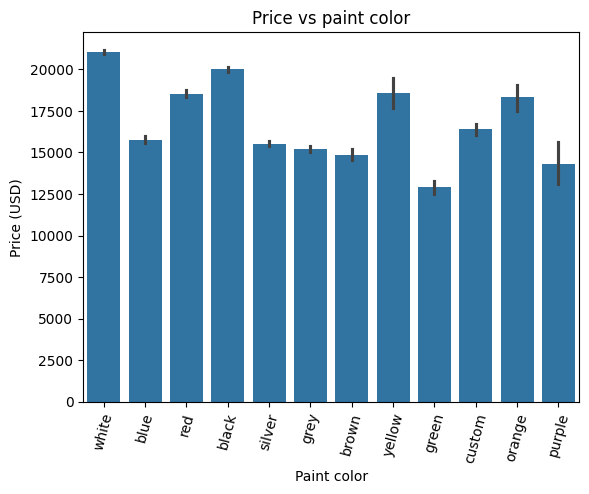

In [23]:
sns.barplot(data=df_clean, x='paint_color', y='price')
plt.title("Price vs paint color")
plt.xlabel("Paint color")
plt.ylabel("Price (USD)")
plt.xticks(rotation=75)
plt.show()

#### Car condition

The condition of a car is naturally an important factor in sale price, but the relationship is not as clear-cut as one might expect. Cars that are in new or like-new condition sell the best, followed very closely by cars in good condition. Cars in fair condition, as well as salvage-worthy cars, sell very poorly. Based on this analysis, I think it may not be worth stocking these kinds of cars in your dealership, unless they can be acquired for a very cheap sum.

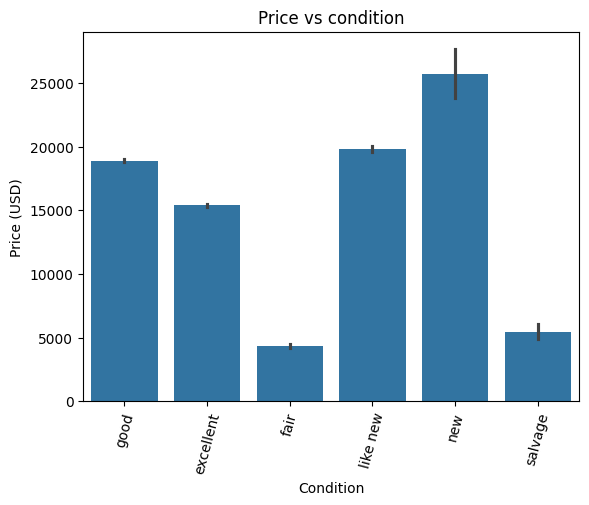

In [24]:
sns.barplot(data=df_clean, x='condition', y='price')
plt.title("Price vs condition")
plt.xlabel("Condition")
plt.ylabel("Price (USD)")
plt.xticks(rotation=75)
plt.show()

#### Number of cylinders in car

Cars with 12 cylinders sell for significantly higher sums than any other number of cylinders. Apart from 12-cylinder engines, the differences between other numbers of cylinders are less significant--although one notable finding is that 5-cylinder engines sell the worst of all. This may be because 5 cylinder engines are a rather uncommon configuration, and may be harder to maintain and find parts for. I would recommend that if you find yourself with a 12-cylinder engine on your lot, make sure to set the price appropriately high--these can sell for an average of nearly \$60k!

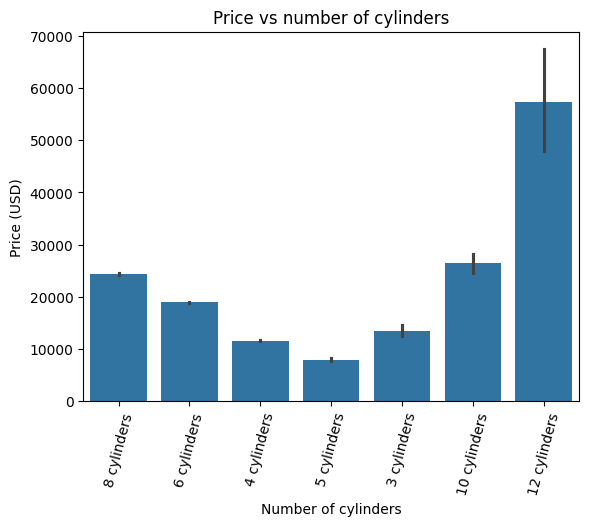

In [25]:
sns.barplot(data=df_clean, x='cylinders', y='price')
plt.title("Price vs number of cylinders")
plt.xlabel("Number of cylinders")
plt.ylabel("Price (USD)")
plt.xticks(rotation=75)
plt.show()

#### Modeling used car sales price

In my analysis, I was able to model the sale prices of used cars using a linear regression model. If you're interested in optimizing your pricing for cars on your lot, or predicting how much a car might sell for before acquiring it for your inventory, you might find such a model helpful. I would recommend a linear model, as it is relatively simple and interpretable, while still able to effectively model the intricacies of car pricing. Using a linear model, I was able to predict used car prices within around \$7.8k of the true vehicle price. See the analysis in the notebook above ("Deployment" section) for further details.